In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset

# 数据集类 - 负责数据加载和预处理
class CustomDataset:
    def __init__(self, x_path, y_path, is_classification=False):
        # 加载数据
        self.x_data = pd.read_csv(x_path)
        self.y_data = pd.read_csv(y_path).values.flatten()
        
        self.is_classification = is_classification
        
        # 数据预处理
        self._preprocess_data()
        
        # 转换为PyTorch张量
        self.x_tensor = torch.tensor(self.x_data.values, dtype=torch.float32)
        self.y_tensor = torch.tensor(self.y_data, dtype=torch.float32).view(-1, 1)
        
    def _preprocess_data(self):
        # 处理非数值列
        for col in self.x_data.columns:
            if self.x_data[col].dtype == 'object':
                try:
                    self.x_data[col] = pd.to_numeric(self.x_data[col])
                except ValueError:
                    self.x_data = pd.get_dummies(self.x_data, columns=[col], drop_first=True)
        
        # 填充缺失值
        self.x_data = self.x_data.fillna(self.x_data.mean())
        
        # 特征标准化
        self.x_data = (self.x_data - self.x_data.mean()) / self.x_data.std()
    
    def get_dataloader(self, batch_size=32, shuffle=True):
        dataset = TensorDataset(self.x_tensor, self.y_tensor)
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    def get_feature_dim(self):
        return self.x_data.shape[1]

# 手动实现的线性模型类
class ManualLinearModel:
    def __init__(self, input_dim, is_classification=False):
        # 手动初始化权重和偏置
        self.weight = torch.randn(input_dim, 1, requires_grad=True)
        self.bias = torch.zeros(1, 1, requires_grad=True)
        
        self.is_classification = is_classification
        
        self.train_losses = []
        self.val_losses = []
    
    def forward(self, x):
        # 手动计算线性变换
        out = torch.matmul(x, self.weight) + self.bias
        if self.is_classification:
            # 手动实现Sigmoid激活
            out = 1 / (1 + torch.exp(-out))
        return out
    
    def fit(self, train_loader, val_loader=None, epochs=100, lr=0.01):
        # 手动选择损失函数
        if self.is_classification:
            def criterion(outputs, labels):
                # 手动实现二元交叉熵损失
                return -torch.mean(labels * torch.log(outputs) + (1 - labels) * torch.log(1 - outputs))
        else:
            def criterion(outputs, labels):
                # 手动实现均方误差损失
                return torch.mean((outputs - labels) ** 2)
        
        # 手动定义参数列表
        parameters = [self.weight, self.bias]
        
        for epoch in range(epochs):
            train_loss = 0.0
            
            for inputs, labels in train_loader:
                # 前向传播
                outputs = self.forward(inputs)
                loss = criterion(outputs, labels)
                
                # 手动清零梯度
                for param in parameters:
                    if param.grad is not None:
                        param.grad.zero_()
                
                # 反向传播
                loss.backward()
                
                # 手动更新参数（梯度下降）
                with torch.no_grad():
                    for param in parameters:
                        param -= lr * param.grad
                
                train_loss += loss.item() * inputs.size(0)
            
            train_loss /= len(train_loader.dataset)
            self.train_losses.append(train_loss)
            
            if val_loader:
                val_loss = 0.0
                with torch.no_grad():
                    for inputs, labels in val_loader:
                        outputs = self.forward(inputs)
                        loss = criterion(outputs, labels)
                        val_loss += loss.item() * inputs.size(0)
                
                val_loss /= len(val_loader.dataset)
                self.val_losses.append(val_loss)
                
                if (epoch + 1) % 10 == 0:
                    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
            else:
                if (epoch + 1) % 10 == 0:
                    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}')
    
    def predict(self, x):
        with torch.no_grad():
            if isinstance(x, pd.DataFrame) or isinstance(x, np.ndarray):
                x_tensor = torch.tensor(x, dtype=torch.float32)
            elif isinstance(x, torch.Tensor):
                x_tensor = x
            
            outputs = self.forward(x_tensor)
            
            if self.is_classification:
                return (outputs >= 0.5).float()
            else:
                return outputs.numpy()
    
    def evaluate(self, test_loader):
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = self.forward(inputs)
                if self.is_classification:
                    preds = (outputs >= 0.5).float()
                else:
                    preds = outputs
                
                all_preds.extend(preds.numpy())
                all_labels.extend(labels.numpy())
        
        all_preds = np.array(all_preds)
        all_labels = np.array(all_labels)
        
        metrics = {}
        
        mse = np.mean((all_preds - all_labels) ** 2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(all_preds - all_labels))
        r2 = 1 - (np.sum((all_labels - all_preds) ** 2) / np.sum((all_labels - np.mean(all_labels)) ** 2))
        
        metrics['mse'] = mse
        metrics['rmse'] = rmse
        metrics['mae'] = mae
        metrics['r2'] = r2
        print(f"均方误差 (MSE): {mse:.4f}")
        print(f"均方根误差 (RMSE): {rmse:.4f}")
        print(f"平均绝对误差 (MAE): {mae:.4f}")
        print(f"R² 分数: {r2:.4f}")
        
        return metrics
    
    def plot_training_curve(self):
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(self.train_losses)+1), self.train_losses, label='loss train')
        if self.val_losses:
            plt.plot(range(1, len(self.val_losses)+1), self.val_losses, label='loss valid')
        plt.xlabel('round')
        plt.ylabel('loss')
        plt.legend()
        plt.grid(True)
        plt.show()

# 可视化训练前后差异的函数
def plot_predictions(y_true, y_pred, is_classification=False, feature=None, feature_name="特征"):
    plt.figure(figsize=(12, 5))
    
    if feature is not None:
        plt.subplot(1, 2, 1)
        plt.scatter(feature, y_true, alpha=0.5)
        plt.xlabel(feature_name)
        plt.ylabel('real')
        plt.title('before train: ' + feature_name + ' vs real')
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        plt.scatter(feature, y_pred, alpha=0.5, color='orange')
        plt.xlabel(feature_name)
        plt.ylabel('pred')
        plt.title('after train: ' + feature_name + ' vs pred')
        plt.grid(True)
    else:
        plt.scatter(range(len(y_true)), y_true, alpha=0.5, label='real')
        plt.scatter(range(len(y_pred)), y_pred, alpha=0.5, color='orange', label='pred')
        plt.xlabel('index')
        plt.ylabel('value')
        plt.title('real vs pred')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

    if not is_classification:
        plt.figure(figsize=(8, 6))
        plt.scatter(y_true, y_pred, alpha=0.5)
        plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
        plt.xlabel('real')
        plt.ylabel('pred')
        plt.title('pred vs real')
        plt.grid(True)
        plt.show()

Epoch [10/100], Train Loss: 0.4150
Epoch [20/100], Train Loss: 0.4146
Epoch [30/100], Train Loss: 0.4146
Epoch [40/100], Train Loss: 0.4146
Epoch [50/100], Train Loss: 0.4146
Epoch [60/100], Train Loss: 0.4146
Epoch [70/100], Train Loss: 0.4146
Epoch [80/100], Train Loss: 0.4146
Epoch [90/100], Train Loss: 0.4146
Epoch [100/100], Train Loss: 0.4146


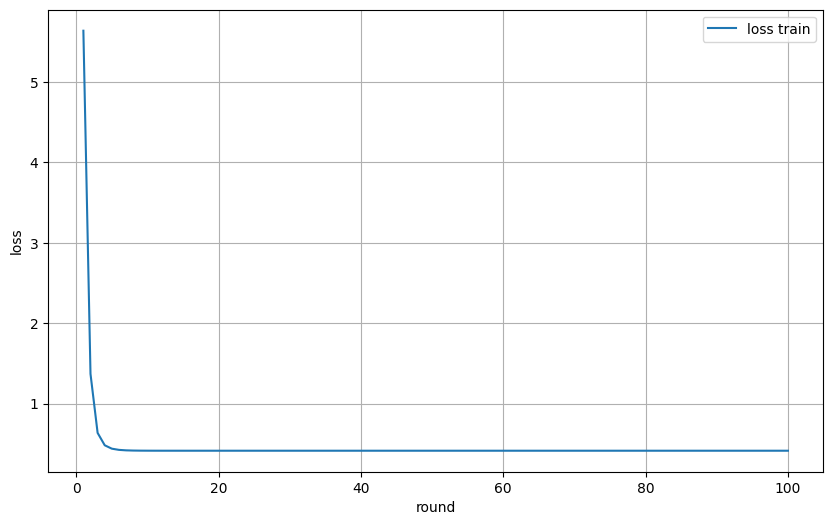

均方误差 (MSE): 0.4145
均方根误差 (RMSE): 0.6438
平均绝对误差 (MAE): 0.4775
R² 分数: 0.5855


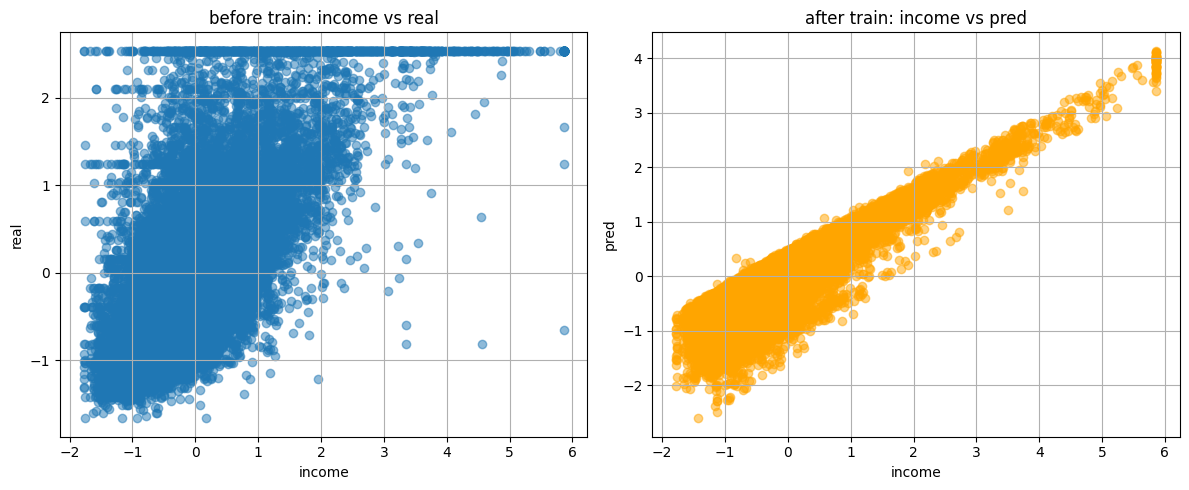

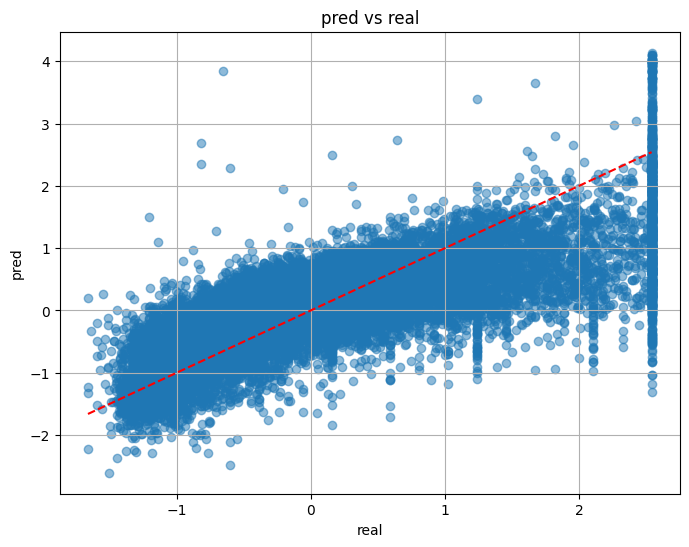

In [18]:
# 假设你已经有了预处理好的X和y数据文件

# 1. 线性回归示例（加州房价数据集）
# 创建数据集实例
housing_dataset = CustomDataset(
    x_path='input.csv', 
    y_path='output.csv',
    is_classification=False
)

# 获取数据加载器
train_loader = housing_dataset.get_dataloader(batch_size=64)

# 创建模型
housing_model = ManualLinearModel(
    input_dim=housing_dataset.get_feature_dim(),
    is_classification=False
)

# 训练模型
housing_model.fit(train_loader, epochs=100, lr=0.001)

# 绘制训练曲线
housing_model.plot_training_curve()

# # 评估模型
metrics = housing_model.evaluate(train_loader)

# # 获取预测结果
y_pred = housing_model.predict(housing_dataset.x_data.values)
y_true = housing_dataset.y_data

# # 绘制训练前后的差异（使用第一个特征进行可视化）
first_feature = housing_dataset.x_data.iloc[:, 0].values
plot_predictions(
    y_true, 
    y_pred, 
    is_classification=False,
    feature=first_feature,
    feature_name="income"
)


# # 2. 逻辑回归示例（泰坦尼克号数据集）
# # 创建数据集实例
# titanic_dataset = CustomDataset(
#     x_path='titanic_x.csv', 
#     y_path='titanic_y.csv',
#     is_classification=True
# )

# # 获取数据加载器
# train_loader = titanic_dataset.get_dataloader(batch_size=32)

# # 创建模型
# titanic_model = MLModel(
#     input_dim=titanic_dataset.get_feature_dim(),
#     is_classification=True
# )

# # 训练模型
# titanic_model.fit(train_loader, epochs=150, lr=0.01)

# # 绘制训练曲线
# titanic_model.plot_training_curve()

# # 评估模型
# metrics = titanic_model.evaluate(train_loader)

# # 获取预测结果
# y_pred = housing_model.predict(titanic_dataset.x_data)
# y_true = titanic_dataset.y_data

# # 绘制训练前后的差异
# first_feature = titanic_dataset.x_data.iloc[:, 0].values
# plot_predictions(
#     y_true, 
#     y_pred, 
#     is_classification=True,
#     feature=first_feature,
#     feature_name="特征1"
# )
